In [ ]:
!pip install open_clip_torch transformers==4.38.2

In [ ]:
!pip install tqdm

In [ ]:
!pip install open_clip_torch

In [3]:
import tqdm.notebook as tqdm
from IPython.display import Image
import json
import pickle
import glob
import os
import open_clip
import torch
from PIL import Image
import numpy as np

# Initial dataset Analysis

In [30]:
!wget http://images.cocodataset.org/zips/train2014.zip

--2024-05-16 21:59:46--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.27.132, 52.216.222.145, 52.216.39.25, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.27.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  1.54MB/s    in 84m 8s  

2024-05-16 23:23:54 (2.55 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]



In [32]:
!wget http://images.cocodataset.org/zips/val2014.zip

--2024-05-16 23:31:55--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.166.75, 52.217.89.52, 3.5.28.55, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.166.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip         100%[===================>]   6.19G  1.67MB/s    in 28m 6s  

2024-05-17 00:00:02 (3.76 MB/s) - ‘val2014.zip’ saved [6645013297/6645013297]



In [31]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip

--2024-05-16 23:23:54--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.136.33, 16.182.107.113, 52.217.73.92, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.136.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_trainval2014.zip’

annotations_trainva 100%[===================>] 241.16M  2.99MB/s    in 75s     

2024-05-16 23:25:10 (3.21 MB/s) - ‘annotations_trainval2014.zip’ saved [252872794/252872794]



In [ ]:
!unzip train2014.zip

In [26]:
!unzip annotations_trainval2014.zip

Archive:  annotations_trainval2014.zip
  inflating: annotations/instances_train2014.json  
  inflating: annotations/instances_val2014.json  
  inflating: annotations/person_keypoints_train2014.json  
  inflating: annotations/person_keypoints_val2014.json  
  inflating: annotations/captions_train2014.json  
  inflating: annotations/captions_val2014.json  


In [ ]:
image_path = glob.glob("train2014/*")[1]
image_path

'train2014/COCO_train2014_000000282069.jpg'

In [40]:
caption_path = 'annotations/captions_train2014.json'
f = open(caption_path)
data = json.load(f)

In [41]:
dict_filename = {}
for image in data['images']:
  dict_filename[image['id']] = image['file_name']

In [42]:
dict_caption = {}
discovered_captions = set()
for caption in tqdm.tqdm(data['annotations']):
  if dict_filename[caption['image_id']] in discovered_captions:
    dict_caption[dict_filename[caption['image_id']]].append(caption['caption'])
  else:
    dict_caption[dict_filename[caption['image_id']]] = [caption['caption']]

  discovered_captions.add(dict_filename[caption['image_id']])


  0%|          | 0/414113 [00:00<?, ?it/s]

In [43]:
with open('image_name_2_captions.pickle', 'wb') as handle:
    pickle.dump(dict_caption, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!cp image_name_2_captions.pickle drive/MyDrive/ECE285/image_name_2_captions.pickle

# Preparing Embeddings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check if the file exists and is not empty
if os.path.exists("drive/MyDrive/ECE285/image_name_2_captions.pickle") and os.path.getsize("drive/MyDrive/ECE285/image_name_2_captions.pickle") > 0:
    with open("drive/MyDrive/ECE285/image_name_2_captions.pickle", mode='rb') as input_file:
        dict_caption = pickle.load(input_file)
else:
    print("The file is empty. Skipping loading data.")

In [ ]:
dict_caption['COCO_train2014_000000282069.jpg']

['A black-and-white photo of a baseball team together.',
 'A baseball team by the name of "proctor" on the uniform, seated for a team photo.',
 'Black and white photo of a baseball team.',
 'A team of baseball players are posing for a group picture.',
 'A baseball team sitting next to each other in a pyramid holding bats.']

In [ ]:
model, _, transform = open_clip.create_model_and_transforms(
  model_name="coca_ViT-L-14",
  pretrained="mscoco_finetuned_laion2B-s13B-b90k"
)

In [ ]:
path = "train2014/"
tokenizer = open_clip.get_tokenizer('coca_ViT-L-14')
for image,captions in tqdm.tqdm(dict_caption.items()):
  if os.path.isfile('drive/MyDrive/ECE285/train_emb/'+image.split('.')[0]+'.npz'):
    continue
  im = Image.open(path+image).convert("RGB")
  im = transform(im).unsqueeze(0)

  with torch.no_grad(), torch.cuda.amp.autocast():
    #image_emb = model.encode_image(im)
    emb = np.vstack([model.encode_image(im)]+[model.encode_text(tokenizer(text)) for text in captions])

  np.save('drive/MyDrive/ECE285/train_emb/'+image.split('.')[0]+'.npz', emb)

  0%|          | 0/82783 [00:00<?, ?it/s]

In [ ]:
!ls

drive  sample_data


In [ ]:
import glob

In [ ]:
ls train_emb | wc -l

48978


In [ ]:
tmp = glob.glob('train_emb/*')

KeyboardInterrupt: 

# Dataset preparation and KNN

Commented the google drive code below and make sure to change the directory to the one where the embeddings are stored.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
cd drive/MyDrive/ECE285

/content/drive/MyDrive/ECE285


In [ ]:
directory = 'train_emb/'

In [ ]:
ls

data_max/  image_name_2_captions.pickle  train_emb/  train_emb.zip  val_emb.zip


In [ ]:
pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.0+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.4/943.4 kB 52.9 MB/s eta 0:00:00


In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.6 MB/s eta 0:00:00


In [11]:
import tqdm.notebook as tqdm
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import scipy
import os
import torch_geometric
import torch.nn as nn
import pickle

In [6]:
!pip install torch_geometric

In [48]:
directory = "train_emb/"
class kNNDataset(Dataset):
    def __init__(self, k = 2, path=directory+"*", cond='max'):
        # if os.path.exists('data_' + cond):
        #   self.img_emb = np.load('data_' + cond +'/img_emb.npy')
        #   self.cap_emb = np.load('data_' + cond +'/cap_emb.npy')
        #   self.kNN = np.load('data_' + cond +'/kNN.npy')
          
        #   return
        os.mkdir('clip_data_' + cond)
        self.img_emb = []
        self.cap_emb = []
        self.image_name = {}
        
        i = 0
        for file in tqdm.tqdm(sorted(glob.glob(path))):
            image_emb = np.load(file)[0]
            caption_emb = np.load(file)[1:]
            self.img_emb.append(image_emb)
            if cond == 'max':
              self.cap_emb.append(caption_emb[np.argmax(np.dot(image_emb,caption_emb.T)/(np.linalg.norm(image_emb)*np.linalg.norm(caption_emb,axis=1)))])
              self.image_name[file] = np.argmax(np.dot(image_emb,caption_emb.T)/(np.linalg.norm(image_emb)*np.linalg.norm(caption_emb,axis=1)))
            elif cond =='avg':
              sim_array = scipy.special.softmax(np.dot(image_emb,caption_emb.T)/(np.linalg.norm(image_emb)*np.linalg.norm(caption_emb,axis=1)))
              self.cap_emb.append(np.sum(sim_array[:, None] * caption_emb, axis = 0))
            i = i + 1
            if i < 10: 
                print(file)

        self.img_emb = np.array(self.img_emb)
        self.cap_emb = np.array(self.cap_emb)
        np.save('clip_data_' + cond +'/img_emb.npy', self.img_emb)
        np.save('clip_data_' + cond +'/cap_emb.npy', self.cap_emb)
        with open('clip_data_' + cond +'/image_name.pickle', 'wb') as handle:
            pickle.dump(self.image_name, handle, protocol=pickle.HIGHEST_PROTOCOL)

        kNN = []
        img_emb = torch.from_numpy(self.img_emb).float()
        for emb in tqdm.tqdm(img_emb):
            distance = torch.nn.functional.cosine_similarity(emb.unsqueeze(0), img_emb)
            k_neigh = distance.topk(k, largest=True)
            kNN.append((k_neigh[0][1:].cpu().numpy(),k_neigh[1][1:].cpu().numpy()))

        self.kNN = np.array(kNN)

        np.save('clip_data_' + cond +'/kNN.npy', self.kNN)


    def __getitem__(self, idx):
        #img embedding, caption embedding, kNN scores, kNN indices
        return torch.from_numpy(self.img_emb[idx]),torch.from_numpy(self.cap_emb[idx]),torch.from_numpy(self.kNN[idx][0]),torch.from_numpy(self.cap_emb[self.kNN[idx][1].astype(np.int32), :])

    def __len__(self):
        return len(self.img_emb)


In [49]:
dataset = kNNDataset()
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

  0%|          | 0/82783 [00:00<?, ?it/s]

train_emb/COCO_train2014_000000000009.npy
train_emb/COCO_train2014_000000000025.npy
train_emb/COCO_train2014_000000000030.npy
train_emb/COCO_train2014_000000000034.npy
train_emb/COCO_train2014_000000000036.npy
train_emb/COCO_train2014_000000000049.npy
train_emb/COCO_train2014_000000000061.npy
train_emb/COCO_train2014_000000000064.npy
train_emb/COCO_train2014_000000000071.npy


  0%|          | 0/82783 [00:00<?, ?it/s]

# Training

# MLP 

In [13]:
class KNN_MLP(nn.Module):
    def __init__(self):
        super(KNN_MLP, self).__init__()
        self.linear1 = nn.Linear(2*768, 2000)
        self.bn1 = nn.BatchNorm1d(2000)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(2000, 768,bias=False)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.linear1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

net = KNN_MLP()
print(net)


KNN_MLP(
  (linear1): Linear(in_features=1536, out_features=2000, bias=True)
  (bn1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (linear2): Linear(in_features=2000, out_features=768, bias=False)
)


In [13]:
criterion = nn.CosineEmbeddingLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [14]:
net.train()

for epoch in range(1):
    total_mse, total_count = 0, 0
    for i, (img_emb, cap_emb, knn, cap_emb_knn) in enumerate(dataloader):
        batch_size = img_emb.size()[0]
        img_emb = img_emb.reshape((-1,1,768))
        cap_emb = cap_emb
        knn = knn
        cap_emb_knn = cap_emb_knn
        weights = torch.nn.functional.softmax(knn,dim=1).unsqueeze(-1)

        avg_cap_emb = torch.mean(weights * cap_emb_knn, dim=1, keepdim=True).float()
        optimizer.zero_grad()
        output = net(torch.cat([img_emb, avg_cap_emb], dim=1))
        loss = criterion(output, cap_emb, torch.ones(batch_size))
        loss.backward()
        optimizer.step()

        total_mse += loss.item()
        total_count += batch_size

    print(f'Epoch: {epoch+1}, Loss: {total_mse/total_count:.4f}')

torch.save(net.state_dict(), 'knn_max_mlp.pt')


Epoch: 1, Loss: 0.0016


# Graph Convolutional Network

Two graph methods __simple__(to the left) and __neighbors__(to the right)


![graph.png](attachment:graph.png)

The graph on the left is for the simplified case where the target node(green) is connected to all the text embeddings(purple) directly. The graph on the right is for the neighbors case where the nodes closest to each other(top k) are connected.

In [5]:
class GraphDataset(torch_geometric.data.InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, cond='max', graph_type='simple', path = directory+"*", k = 11):
        self.graph_type = graph_type
        if os.path.exists('data_' + cond):
          self.img_emb = np.load('data_' + cond +'/img_emb.npy')
          self.cap_emb = np.load('data_' + cond +'/cap_emb.npy')
          self.kNN = np.load('data_' + cond +'/kNN.npy')
        else:
            os.mkdir('data_' + cond)
            self.img_emb = []
            self.cap_emb = []
            for file in tqdm.tqdm(glob.glob(path)):
                image_emb = np.load(file)[0]
                caption_emb = np.load(file)[1:]
                self.img_emb.append(image_emb)
                if cond == 'max':
                    self.cap_emb.append(caption_emb[np.argmax(np.dot(image_emb,caption_emb.T)/(np.linalg.norm(image_emb)*np.linalg.norm(caption_emb,axis=1)))])
                elif cond =='avg':
                    sim_array = scipy.special.softmax(np.dot(image_emb,caption_emb.T)/(np.linalg.norm(image_emb)*np.linalg.norm(caption_emb,axis=1)))
                    self.cap_emb.append(np.sum(sim_array[:, None] * caption_emb, axis = 0))



            self.img_emb = np.array(self.img_emb)
            self.cap_emb = np.array(self.cap_emb)

            kNN = []
            img_emb = torch.from_numpy(self.img_emb).float().cuda()
            for emb in tqdm.tqdm(img_emb):
                distance = torch.nn.functional.cosine_similarity(emb.unsqueeze(0), img_emb)
                k_neigh = distance.topk(k, largest=True)
                kNN.append((k_neigh[0][1:].cpu().numpy(),k_neigh[1][1:].cpu().numpy()))

            self.kNN = np.array(kNN)

            np.save('data_' + cond +'/kNN.npy', self.kNN)
            np.save('data_' + cond +'/img_emb.npy', self.img_emb)
            np.save('data_' + cond +'/cap_emb.npy', self.cap_emb)


        super(GraphDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        pass

    def process(self):
        data_list = []

        for i in tqdm.tqdm(range(len(self.img_emb))):
            data = self.build_graph(i)
            data_list.append(data)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def build_graph(self, idx):
        img_emb = torch.from_numpy(self.img_emb[self.kNN[idx][1].astype(np.int32), :])
        cap_emb = torch.from_numpy(self.cap_emb[self.kNN[idx][1].astype(np.int32), :])

        if self.graph_type == 'simple':
            edge_index = torch.tensor([np.concatenate([np.zeros(len(self.kNN[idx][0])),np.arange(1, len(self.kNN[idx][0])+1)]),np.concatenate([np.arange(1, len(self.kNN[idx][0])+1) ,np.zeros(len(self.kNN[idx][0]))])],dtype=torch.long)
            edge_weights = torch.tensor(self.kNN[idx][0])
            edge_weights = torch.cat([edge_weights, edge_weights])

        elif self.graph_type == 'neighbors':

            img_emb = torch.cat([torch.tensor(self.img_emb[idx][None, :]), img_emb])
            adj_dict = {}
            for idx, emb in enumerate(img_emb):
                dist = torch.nn.functional.cosine_similarity(emb.unsqueeze(0), img_emb)
                k_neigh = dist.topk(4, largest=True)
                for i in range(1,4):
                    if str(idx)+'_'+str(k_neigh[1][i].item()) not in adj_dict:
                        adj_dict[str(idx)+'_'+str(k_neigh[1][i].item())] = k_neigh[0][i].item()
                        adj_dict[str(k_neigh[1][i].item())+'_'+str(idx)] = k_neigh[0][i].item()

            edges = torch.tensor([[int(key.split('_')[0]), int(key.split('_')[1]), adj_dict[key]] for key in adj_dict],dtype=torch.double).T
            edge_index = edges[:2]
            edge_weights = torch.tensor(edges[2].clone().detach(),dtype=torch.double)


        return torch_geometric.data.Data(x=torch.cat([torch.from_numpy(self.img_emb[idx][None, :]), cap_emb]), edge_index=edge_index, edge_attr=edge_weights, y=torch.from_numpy(self.cap_emb[idx]))

In [6]:
batch_size = 32
k = 10
graph_dataset = GraphDataset(root='.', cond='max', graph_type='neighbors')
graph_dataloader = torch_geometric.loader.DataLoader(graph_dataset, batch_size=batch_size, shuffle=True)

Processing...


  0%|          | 0/40504 [00:00<?, ?it/s]

/var/folders/dn/yxnpmkhd05g6g_xxb6ktgr840000gn/T/ipykernel_53760/1897857124.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_weights = torch.tensor(edges[2].clone().detach(),dtype=torch.double)


KeyboardInterrupt: 

In [ ]:
class GraphConvolution(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GraphConvolution, self).__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels

        self.conv1 = torch_geometric.nn.GCNConv(in_channels, hidden_channels)
        self.conv2 = torch_geometric.nn.GCNConv(hidden_channels, in_channels)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x.to(torch.float32), edge_index, edge_attr)
        return x

graphNet = GraphConvolution(768, 4*768).cuda()

In [ ]:
criterion = nn.CosineEmbeddingLoss()
graph_optimizer = torch.optim.Adam(graphNet.parameters(), lr=0.01)

In [ ]:
graphNet.train()
for epoch in range(100):
    for i, data in enumerate(graph_dataloader):
        data = data.to('cuda')
        graph_optimizer.zero_grad()
        output = graphNet(data.x, data.edge_index.to(torch.long), data.edge_attr)
        loss = criterion(output.reshape(-1, k + 1, 768)[:,0,:], data.y.reshape(-1, 768), torch.ones(data.y.reshape(-1, 768).size(0)).cuda())
        loss.backward()
        print(loss.item())
        graph_optimizer.step()


    print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

torch.save(net.state_dict(), 'knn_max_gcn.pt')

## Cross Attention Transformer

![alt text](https://github.com/AnandK27/nice-retreiver/blob/main/image.png?raw=1)

In [ ]:
def positional_encoding(max_len, d_model):
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1).float()
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, q, k, v):
        batch_size = q.size(0)
        scores = torch.einsum("bhqd,bhkd->bhqk", q, k) / np.sqrt(self.d_k)
        attention = torch.nn.functional.softmax(scores, dim=2)
        return torch.einsum("bhqv,bhvd->bhqd", attention, v)

    def split_heads(self, x, batch_size):
        return x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

    def group_heads(self, x, batch_size):
        return x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)

    def forward(self, q, k, v):
        batch_size = q.size(0)
        q, k, v = [l(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2) for l, x in zip(self.linear_layers, (q, k, v))]
        x = self.scaled_dot_product_attention(q, k, v)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        return self.output_linear(x)


class SelfAttentionBlock(nn.Module):
    def __init__(self, d_model, num_heads):
        super(SelfAttentionBlock, self).__init__()
        self.multi_head_attention = MultiHeadAttention(d_model, num_heads)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.linear1 = nn.Linear(d_model, 4 * d_model)
        self.dropout = nn.Dropout(0.1)
        self.linear2 = nn.Linear(4 * d_model, d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = x + self.multi_head_attention(x, x, x)
        x_1 = self.layer_norm1(x)
        x = self.linear2(self.dropout(torch.nn.functional.relu(self.linear1(x_1))))
        x = x + self.dropout(x_1)
        x = self.layer_norm2(x)
        return x

class CrossAttentionBlock(nn.Module):
    def __init__(self, d_model, num_heads):
        super(CrossAttentionBlock, self).__init__()
        self.multi_head_self_attention = MultiHeadAttention(d_model, num_heads)
        self.multi_head_cross_attention = MultiHeadAttention(d_model, num_heads)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.linear1 = nn.Linear(d_model, 4 * d_model)
        self.dropout = nn.Dropout(0.1)
        self.linear2 = nn.Linear(4 * d_model, d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)

    def forward(self, x, y):
        x = x + self.multi_head_self_attention(x, x, x)
        x = x + self.multi_head_cross_attention(x, y, y)
        x_1 = self.layer_norm1(x)
        x = self.linear2(self.dropout(torch.nn.functional.relu(self.linear1(x_1))))
        x = x + self.dropout(x_1)
        x = self.layer_norm2(x)
        return x

class CrossAttentionTransformer(nn.Module):
    def __init__(self, d_model, num_heads, num_layers):
        super(CrossAttentionTransformer, self).__init__()
        self.self_attention_blocks = nn.ModuleList([SelfAttentionBlock(d_model, num_heads) for _ in range(num_layers)])
        self.cross_attention_blocks = nn.ModuleList([CrossAttentionBlock(d_model, num_heads) for _ in range(num_layers)])
        self.learnable_embedding = nn.Parameter(torch.zeros((1,d_model)))

    def forward(self, y):
        x = self.learnable_embedding.repeat(y.size(0), 1, 1)
        pe = positional_encoding(y.size(1), y.size(2)).cuda()
        y = y + pe[None, :, :]
        for block in self.self_attention_blocks:
            y = block(y)
        for block in self.cross_attention_blocks:
            x = block(x, y)
        return x

transformerNet = CrossAttentionTransformer(768, 4, 4).cuda()

In [ ]:
criterion = nn.CosineEmbeddingLoss()
transformer_optimizer = torch.optim.Adam(transformerNet.parameters(), lr=0.001)

In [ ]:
transformerNet.train()
for epoch in range(100):
    for i, (img_emb, cap_emb, knn, cap_emb_knn) in enumerate(dataloader):
        batch_size = img_emb.size()[0]
        img_emb = img_emb.cuda().reshape((-1,1,768))
        cap_emb = cap_emb.cuda()
        knn = knn.cuda()
        cap_emb_knn = cap_emb_knn.cuda()

        transformer_optimizer.zero_grad()
        output = transformerNet(torch.cat([img_emb, cap_emb_knn], dim=1))
        loss = criterion(output.squeeze(1), cap_emb, torch.ones(batch_size).cuda())
        loss.backward()
        transformer_optimizer.step()


    print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')

torch.save(transformerNet.state_dict(), 'knn_max_transformer.pt')


Epoch: 1, Loss: 0.4243
Epoch: 2, Loss: 0.4226


KeyboardInterrupt: 

# Validation


In [6]:
import tqdm.notebook as tqdm
from IPython.display import Image
import json
import pickle
import glob
import os
import open_clip
import torch
from PIL import Image
import numpy as np
import tqdm.notebook as tqdm
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import scipy
import os
import torch_geometric
import torch.nn as nn
import matplotlib.pyplot as plt

In [7]:
import numpy as np


directory = "val_emb/"
class ValidationDataset():
    def __init__(self, path=directory+"*", cond='max'):
        if os.path.exists('val_data_' + cond):
          self.img_emb = np.load('val_data_' + cond +'/img_emb.npy')
          self.cap_emb = np.load('val_data_' + cond +'/cap_emb.npy')
          self.knowledge_emb = np.load('data_' + cond +'/img_emb.npy')
          self.kNN = np.load('data_' + cond +'/kNN.npy')
          with open('val_data_' + cond +'/image_name.npy', mode='rb') as input_file:
            self.image_name = pickle.load(input_file)
          return
        os.mkdir('val_data_' + cond)
        self.knowledge_emb = np.load('data_' + cond +'/img_emb.npy')
        self.img_emb = []
        self.cap_emb = []
        self.image_name = {}
        i = 0 
        for file in tqdm.tqdm(glob.glob(path)):
            image_emb = np.load(file)[0]
            caption_emb = np.load(file)[1:]
            self.img_emb.append(image_emb)
            if cond == 'max':
              self.cap_emb.append(caption_emb[np.argmax(np.dot(image_emb,caption_emb.T)/(np.linalg.norm(image_emb)*np.linalg.norm(caption_emb,axis=1)))])
              self.image_name[file] = np.argmax(np.dot(image_emb,caption_emb.T)/(np.linalg.norm(image_emb)*np.linalg.norm(caption_emb,axis=1)))
            elif cond =='avg':
              sim_array = scipy.special.softmax(np.dot(image_emb,caption_emb.T)/(np.linalg.norm(image_emb)*np.linalg.norm(caption_emb,axis=1)))
              self.cap_emb.append(np.sum(sim_array[:, None] * caption_emb, axis = 0))
            i = i+1

        self.img_emb = np.array(self.img_emb)
        self.cap_emb = np.array(self.cap_emb)

        np.save('val_data_' + cond +'/img_emb.npy', self.img_emb)
        np.save('val_data_' + cond +'/cap_emb.npy', self.cap_emb)
        with open('val_data_' + cond +'/image_name.npy', 'wb') as handle:
            pickle.dump(self.image_name, handle, protocol=pickle.HIGHEST_PROTOCOL)

        kNN = []
        k = 10
        img_emb = torch.from_numpy(self.img_emb).float()
        for emb in tqdm.tqdm(self.knowledge_emb):
            distance = torch.nn.functional.cosine_similarity(torch.tensor(emb).unsqueeze(0), img_emb)
            k_neigh = distance.topk(k, largest=True)
            kNN.append((k_neigh[0].cpu().numpy(),k_neigh[1].cpu().numpy()))

        self.kNN = np.array(kNN)

        np.save('val_data_' + cond +'/kNN.npy', self.kNN)

    def __getitem__(self, idx):
        #img embedding, caption embedding, kNN scores, kNN indices
        return self.image_name[idx],torch.from_numpy(self.img_emb[idx]),torch.from_numpy(self.cap_emb[idx]),torch.from_numpy(self.kNN[idx][0]),torch.from_numpy(self.cap_emb[self.kNN[idx][1].astype(np.int32), :])

    def __len__(self):
        return len(self.img_emb)

val_dataset = ValidationDataset()
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)



In [21]:
x = torch.randn(4, 4)

In [22]:
x

tensor([[ 0.3822, -0.5698, -0.8609,  0.0019],
        [ 0.2049,  0.4245,  0.8959, -1.0614],
        [-1.3990,  0.7958,  1.2672,  1.3473],
        [-0.0153,  0.4535,  1.6236, -0.4029]])

In [8]:
val_dataset = ValidationDataset()
inference_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [9]:
model, _, transform = open_clip.create_model_and_transforms(
  model_name="coca_ViT-L-14",
  pretrained="mscoco_finetuned_laion2B-s13B-b90k"
)

In [49]:
caption_path = 'annotations/captions_val2014.json'
f = open(caption_path)
data = json.load(f)

dict_filename = {}
for image in data['images']:
  dict_filename[image['id']] = image['file_name']

In [50]:
dict_val_caption = {}
discovered_captions = set()
for caption in tqdm.tqdm(data['annotations']):
  if dict_filename[caption['image_id']] in discovered_captions:
    dict_val_caption[dict_filename[caption['image_id']]].append(caption['caption'])
  else:
    dict_val_caption[dict_filename[caption['image_id']]] = [caption['caption']]

  discovered_captions.add(dict_filename[caption['image_id']])


  0%|          | 0/202654 [00:00<?, ?it/s]

In [51]:
with open('image_name_2_captions_val.pickle', 'wb') as handle:
    pickle.dump(dict_val_caption, handle, protocol=pickle.HIGHEST_PROTOCOL)

['A plate that is flying in the air during the day.', 'A white airplane that is flying in the sky.', 'A photograph of an air plane about to land.', "Jet, with it's landing gears out, flying in the sky", 'The plain has already taken off and in flight.']
torch.Size([6, 255, 768]) torch.Size([6, 1, 768])
torch.Size([6, 255, 768]) torch.Size([6, 2, 768])
torch.Size([6, 255, 768]) torch.Size([6, 3, 768])
torch.Size([6, 255, 768]) torch.Size([6, 4, 768])
torch.Size([6, 255, 768]) torch.Size([6, 5, 768])
torch.Size([6, 255, 768]) torch.Size([6, 6, 768])
torch.Size([6, 255, 768]) torch.Size([6, 7, 768])
torch.Size([6, 255, 768]) torch.Size([6, 8, 768])
torch.Size([6, 255, 768]) torch.Size([6, 9, 768])
torch.Size([6, 255, 768]) torch.Size([6, 10, 768])
torch.Size([6, 255, 768]) torch.Size([6, 11, 768])
torch.Size([6, 255, 768]) torch.Size([6, 12, 768])
torch.Size([6, 255, 768]) torch.Size([6, 13, 768])
torch.Size([6, 255, 768]) torch.Size([6, 14, 768])
torch.Size([6, 255, 768]) torch.Size([6, 1

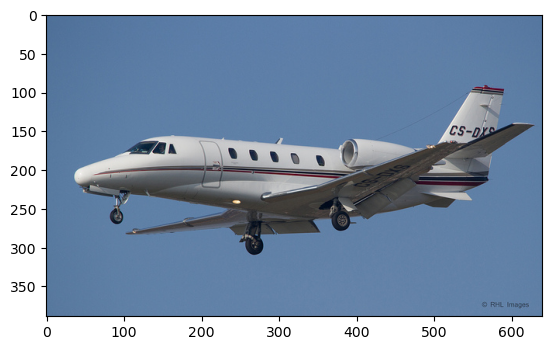

In [52]:
path = "val2014/"
net.eval()
total_mse, total_count = 0, 0
validation_output = {}
with torch.no_grad():
    for i, (image_name, img_emb, cap_emb, knn, cap_emb_knn) in enumerate(inference_dataloader):
        batch_size = img_emb.size()[0]
        img_emb = img_emb.reshape((-1,1,768))*0
        cap_emb = cap_emb
        knn = knn
        cap_emb_knn = cap_emb_knn
        weights = torch.nn.functional.softmax(knn,dim=1).unsqueeze(-1)
        
        avg_cap_emb = torch.mean(weights * cap_emb_knn, dim=1, keepdim=True).float()
        output = net(torch.cat([img_emb, avg_cap_emb], dim=1))

        image = image_name[0].split("/")[1].split(".")[0]
        im = Image.open(path+image+".jpg").convert("RGB")
        plt.imshow(im)
        im = transform(im).unsqueeze(0)

        print(dict_val_caption[image+".jpg"])

        
        text = model.generate(im, image_latent=img_emb)

        text = open_clip.decode(text[0]).split("<end_of_text>")[0].replace("<start_of_text>","")
        print(text)
        break

        loss = criterion(output, cap_emb, torch.ones(batch_size))

        total_mse += loss.item()
        total_count += batch_size

# print(f' Loss: {total_mse/total_count:.4f}')




In [34]:
# Check if the file exists and is not empty
if os.path.exists("image_name_2_captions.pickle") and os.path.getsize("image_name_2_captions.pickle") > 0:
    with open("image_name_2_captions.pickle", mode='rb') as input_file:
        dict_caption = pickle.load(input_file)
else:
    print("The file is empty. Skipping loading data.")

In [39]:
len(dict_caption)

'COCO_train2014_000000318556.jpg'

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from collections import defaultdict

# Assuming you have access to reference captions and candidate captions
reference_captions = [
    ["a dog is playing with a ball in the park", "a dog plays with a ball outside"],
    ["a child is riding a horse in the field", "a young rider on a horse in the countryside"]
]

candidate_captions = [
    "a dog is playing outside",
    "the child is riding a horse in a field"
]

# Function to calculate BLEU scores
def calculate_bleu(reference, candidate):
    reference_tokens = [ref.split() for ref in reference]
    candidate_tokens = candidate.split()
    smoothing = SmoothingFunction().method1  # Can choose different methods
    score = sentence_bleu(reference_tokens, candidate_tokens, smoothing_function=smoothing)
    return score

# Function to calculate CIDEr scores
# NLTK does not directly support CIDEr, so we typically use other libraries or implement it manually.
# However, for simplicity, let's use METEOR as an alternative here, as an example.
def calculate_meteor(reference, candidate):
    score = meteor_score(reference, candidate)
    return score

# Calculate scores for each caption
for ref, cand in zip(reference_captions, candidate_captions):
    bleu_score = calculate_bleu(ref, cand)
    meteor_score = calculate_meteor(ref, cand)
    print(f"Reference: {ref}")
    print(f"Candidate: {cand}")
    print(f"BLEU Score: {bleu_score:.4f}")
    print(f"METEOR Score: {meteor_score:.4f}")
    print("-" * 50)
